In [2]:
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
import random
from nltk.collocations import *
import dill
import string
import re
from nltk.tokenize import RegexpTokenizer
import time

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<h1>Define N-gram Feature Exractor Functions</h1>

In [4]:
# Unigram Only Extractor
def unigram_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

In [156]:
# Combined Unigram + Bigram Extractor
def bigram_document_features(document, word_features, bigram_features): 
    document_words = set(document) 
    document_bigrams = nltk.bigrams(document) 
    features = {}
    for word in word_features:
        features[f"W_{word}"] = (word in document_words)
    for bigram in bigram_features:
        features[f"B_{bigram[0]}_{bigram[1]}"] = (bigram in document_bigrams)
    return features
    print(features)

<h1>Define Cross Validation Function</h1>

In [4]:
def cross_validation_accuracy(num_folds, featuresets):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    accuracy_list = []
    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)
        print (i, accuracy_this_round)
        accuracy_list.append(accuracy_this_round)
        
    # find mean accuracy over all rounds
    print ('mean accuracy', sum(accuracy_list) / num_folds)

<h1> Define Evaluation Metrics Function: Precision, Recall, F1, and Specificity</h1>

In [5]:
######### EVALUATE PRECISION, RECALL, F1, AND SPECIFICITY FOR EACH LABEL
def eval_measures(gold, predicted):
    # get a list of labels
    labels = list(set(gold))
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []
    specificity_list =[]
    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        specificity = TN / (TN + FP)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append( 2 * (recall * precision) / (recall + precision))
        specificity_list.append(specificity)

    # the evaluation measures in a table with one row per label
    print('\n\nEvaluation_Metrics----\n\n\tPrecision\tRecall\t    F1\t Specificity')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]),"{:10.3f}".format(specificity_list[i]))

<h1>Define Confusion Matrix and Eval Metrics Function</h1>

In [6]:
def cm_eval_print(test_set):

    goldlist = []
    predictedlist = []

    for (features, label) in test_set:
        goldlist.append(label)
        predictedlist.append(NBclassifier.classify(features))
        
    cm = nltk.ConfusionMatrix(goldlist, predictedlist)

    print("\nConfusion_Matrix----\n\n", cm.pretty_format(sort_by_count=True))
    
    eval_measures(goldlist, predictedlist)

<h1>Loading and Examining the Dataset</h1> 
<br>
<body>In the interest of familiarizing ourselves with the data quickly, we will start out by looking at only a portion of it. Specfically, we will start out by analyzing only the "title" field of the dataset, which is the headlines of the news items. We will do minimal pre-processing, extract unigrams, and use them to train a Naive Bayes Classifier to establish a baseline of accuracy and take an initial look at informative features.</body>
<h3>Load the unfiltered dataset </h3>

In [23]:
df = pd.read_csv('~/WELFake_Dataset.csv', 
                 index_col='index', 
                 header=0,
                 names=['index', 'title', 'text', 'label'])
df

,title,text,label
index,,,
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0


<h2> Minimal pre-processing</h2>
<h3> Drop rows with empty fields </h3>

In [24]:
df
print(len(df))
df = df.dropna()
print(len(df))

72134
71537


In [332]:
print(f"Number of NaN fields in the original dataset: {72134 - 71537}")

Number of NaN fields in the original dataset: 597


<h3>Balance fake and real labels</h3>

In [25]:
print("Number of fakenews items:", df['label'].value_counts()[1])
print("Number of real news items:", df['label'].value_counts()[0])

Number of fakenews items: 36509
Number of real news items: 35028


In [26]:
# balance labels
rows_to_delete = df[df['label'] == 1].head(740) + df[df['label'] == 1].tail(741)
df = df.drop(rows_to_delete.index)

# confirm labels are now balanced
count = (df['label'].value_counts()[1])-(df['label'].value_counts()[0])
print("Difference between fake (1) and real (0) count:", count)

Difference between fake (1) and real (0) count: 0


<h3>Re-shuffle the rows of the dataset</h3>

In [43]:
df = df.sample(frac=1)

In [45]:
print("Current number of rows in the dataset:", len(df))

Current number of rows in the dataset: 70056


In [188]:
min_process_df = df

<h3>EXPORT to CSV: Minimally Processed Dataset</h3>

In [189]:
# EXPORT REVISED DATAFRAME TO CSV FOR FUTURE USE SO RANDOMIZATION WILL NOT BE A VARIABLE

min_process_df.to_csv('~/min_process_fakenews_df_canonical.csv ', index=False, sep=',')

<h1>TEST 1: Create Unigram Features: Unfiltered, Titles-Only </h1>

<h1>Define the Unigram Extraction Function</h1>

In [241]:
# LOAD THE MINIMALLY PRE-PROCESSED DATASET

df = pd.read_csv('~/min_process_fakenews_df_canonical.csv', 
                 index_col=None, 
                 header=0,
                 names=['title', 'text', 'label'])

In [563]:
# make a tuple of title, label for each row in the df
tuple_rows = list(df.itertuples(index=False, name=None))

In [564]:
# tokenize and lowercase the words in the title
title_words_tuple = [(word_tokenize(title[0].lower()), title[2]) for title in tuple_rows]
documents = title_words_tuple

In [565]:
# print an example document to confirm everything looks right
print(title_words_tuple[2])

(['help', 'blow', 'up', 'the', 'globalists', 'plot', 'to', 'steal', 'the', 'presidency-', 'make', 'this', 'go', 'viral'], 1)


In [566]:
# Create a list of unique words in the corpus
all_words_list = [word for (title, cat) in documents for word in title]
print(f"There are {len(all_words_list)} words in the unfiltered title-only corpus.")
print(f"There are {len(set(all_words_list))} unique words in the unfilted title-only corpus.")

There are 995190 words in the unfiltered title-only corpus.
There are 38811 unique words in the unfilted title-only corpus.


In [567]:
# Normalize the word list by frequency and select the 3000 most common unique words as our vocabulary
all_words = nltk.FreqDist(all_words_list)
word_items = all_words.most_common(3000)

In [568]:
# define the unigram features variable
title_features = [word for (word,count) in word_items]

In [569]:
# define the title featureset variable
title_featuresets = [(unigram_features(title, title_features), cat) for (title, cat) in documents]

<h3>Train and Test Naive Bayes Classifier on the Unigram Features</h3>

In [570]:
# define a 70:30 train/test ratio
train_set, test_set = title_featuresets[(round(.30 * len(title_featuresets))):], title_featuresets[:(round(.30 * len(title_featuresets)))]

In [571]:
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)

In [572]:
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

In [573]:
print(accuracy)

0.8838083456249702


<h4>Test 1 Most Informative Features</h4>

In [81]:
print("1 = Fake / 0 = Real")
NBclassifier.show_most_informative_features(25)

1 = Fake / 0 = Real
Most Informative Features
                     V_[ = True                1 : 0      =   1442.0 : 1.0
                     V_] = True                1 : 0      =   1442.0 : 1.0
                   V_wow = True                1 : 0      =    161.7 : 1.0
               V_myanmar = True                0 : 1      =    140.4 : 1.0
                     V_“ = True                1 : 0      =    129.2 : 1.0
                     V_” = True                1 : 0      =    127.0 : 1.0
                 V_video = True                1 : 0      =     70.1 : 1.0
               V_awesome = True                1 : 0      =     63.9 : 1.0
             V_brilliant = True                1 : 0      =     61.9 : 1.0
             V_bombshell = True                1 : 0      =     60.8 : 1.0
           V_hilariously = True                1 : 0      =     58.6 : 1.0
                     V_! = True                1 : 0      =     58.2 : 1.0
                V_insane = True                1 : 0  

In [574]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 10
cross_validation_accuracy(num_folds, title_featuresets)

Each fold size: 7005
0 0.8792291220556745
1 0.8850820842255531
2 0.8852248394004283
3 0.8866523911491792
4 0.8809421841541756
5 0.8795146324054247
6 0.8822269807280514
7 0.8843683083511777
8 0.8765167737330478
9 0.8795146324054247
mean accuracy 0.8819271948608136


In [ ]:
goldlist = []
predictedlist = []

for (features, label) in test_set:
    goldlist.append(label)
    predictedlist.append(NBclassifier.classify(features))

cm = nltk.ConfusionMatrix(goldlist, predictedlist)

In [583]:
print(cm.pretty_format(sort_by_count=True))

  |    1    0 |
--+-----------+
1 |<8846>1712 |
0 |  730<9729>|
--+-----------+
(row = reference; col = test)



In [620]:
eval_measures(goldlist, predictedlist)

	Precision	Recall	    F1	 Specificity
0 	      0.850      0.930      0.888      0.838
1 	      0.924      0.838      0.879      0.930


<h3>Test 1 Discussion: NB Classifier on Unigram Features of the Minimally Processed Dataset</h3>

<body>Although we have already achieved impressive results with the minimally pre-processed title-only corpus using the <b>Naive Bayes Classifier on unigram features, scoring 88.1% mean accuracy with 10-fold cross evaluation,</b> when we look at the <b>Most Informative Features</b>, we see some irregularities. Some of the features, such as "wow", "awesome", "shocking", and even "!" are plausible sytlistic distinguishing features for fakenews, indicative of a more sensationalistic rhetorical style.  
<br><br>When we look at the detailed evalauation metrics, we see that the <b>F1 Score for both the positive and negative label are close to each other and to the mean accuracy</b>, suggesting that the model is generally well-balanced.   
 <br><br>However, the two <b>Most Informative Features are open and closed square brackets</b>, and in the top ten, we also have the word "video" as well as double quotation marks. These seem arbitrary and are less plausible as truly informative features. One possible explanation is that we are seeing <b>over-fitting due to imbalances in the dataset</b>, e.g. headline labels such as "[VIDEO]" might consistently come from a single fakenews source that happens to format video titles this way. 
<br><br>
Interestingly, though the outliers in Most Informative Features predict positive labels, in the detailed evaluation metrics, we see that <b>Recall</b>, or sensitivity, is higher for the negative label assignment. We also see that <b>Precision and Specificty for postive (fake) label prediction is quite high at 92.4% and 93%</b> respectively, indicating that there are unigram features that are highly predictive of a positive label, with realitively few false positives. 
<br><br>Though this minimally processed featureset gives us a high level of accuracy, the model will not generalize well in a dataset that does not have this imbalance. To correct this, we will perform some standard text pre-processing and check our results...</body>

<h1>Pre-Processing</h1><br>
<body>In order to maintain flexibility for future use, we will tokenize and pre-process both the "title" (headline) and "text" (news item body) in the dataset separately before re-exporting the processed text to a csv.
<br><br>Because there are some stylistically signficant puncutation marks we will want to keep and some unusual tokens, such as censored expletives using '*' vowel replacement and hashtags that we will want to treat differently than the word_tokenize method, we will use the NLTK <b>RegexpTokenizer</b>.
<br><br>We will use the NLTK <b>Snowball Stemmer</b> to stem tokens.
</body>
<h3>Creating Custom Filters for Non-Significant Punctuation and Stopwords + Stemming</h3>

In [18]:
# SELECT STEMMER
stemmer = nltk.SnowballStemmer('english')

# STOPWORDS TO FILTER OUT
stopwords = nltk.corpus.stopwords.words('english')

# NEGATION WORDS TO KEEP
negationwords = ['no', 'not', 'never', 'none', 'nowhere', 'nothing', 'no one', 'rather', 'hardly', 'scarcely', 'rarely', 'seldom', 'neither', 'nor']

# WORDS TO FILTER OUT
filter_words = [word for word in stopwords if word not in negationwords]

# STYLISTICALLY SIGNIFICANT PUNCTUATION TO KEEP
style_punct = ['!', '#', '*']

# STYLISTICALLY INSIGNIFICANT PUNCT NOT INCLUDED IN string.punctuation BUT FOUND IN THE DATASET
extra_punct = ["’", "”", "”", "‹", "›", "'s","“"]

In [14]:
def clean_text(text):
    # Lowercase the text and remove unwanted characters
    text = "".join([word.lower() for word in text if (word not in string.punctuation and 
    word not in extra_punct) or word in style_punct])
    
    # Define a RegexpTokenizer that tokenizes asteriks within words (e.g. for obscuring expletives)
    # and keeps hashes with hashtags
    tokenizer = RegexpTokenizer(r'[A-Za-z*]+|\S+')

    # Tokenize the cleaned text
    tokens = tokenizer.tokenize(text)
    
    # stem words using Snowball Stemmer
    text = [stemmer.stem(word) for word in tokens if word not in filter_words]

    return text

In [454]:
# # LOAD THE MINIMALLY PRE-PROCESSED DATASET IF NEEDED
# df = pd.read_csv('~/min_process_fakenews_df_canonical.csv', 
#                  index_col=None, 
#                  header=0,
#                  names=['title', 'text', 'label'])

In [455]:
# make a tuple of title, label for each row in the df
fulltext_label_tuple = list(df.itertuples(index=False, name=None))

In [470]:
# CLEAN THE TEXT 
documents = [(clean_text(i[0]),clean_text(i[1]), i[2]) for i in fulltext_label_tuple]

In [471]:
# Check an entry with focus tokens (e.g. internal '*' and '!')
documents[70055]

(['grow',
  'f*ck',
  '!',
  'trump',
  'get',
  'taken',
  'woodsh',
  'call',
  'govern',
  'shutdown'],
 ['yesterday',
  'amateur',
  'presid',
  'donald',
  'trump',
  'made',
  'ass',
  'fail',
  'histori',
  'today',
  'call',
  'futur',
  'govern',
  'shutdown',
  'trump',
  'could',
  'f*ck',
  'past',
  'futur',
  '24hour',
  'trump',
  'want',
  'shut',
  'govern',
  'lead',
  'thing',
  'real',
  'presid',
  'would',
  'tri',
  'avoid',
  'former',
  'presid',
  'barack',
  'obama',
  'made',
  'concess',
  'order',
  'avoid',
  'govern',
  'shutdown',
  'manbabi',
  'potus',
  'whine',
  'twitter',
  'deal',
  'reach',
  '1',
  'trillionplus',
  'bill',
  'fund',
  'govern',
  'final',
  'five',
  'month',
  'fiscal',
  'yeareven',
  'though',
  'republican',
  'control',
  'congress',
  'senat',
  'instal',
  'republican',
  'presid',
  'trump',
  'not',
  'get',
  'fund',
  'ineffect',
  'border',
  'wall',
  'taxpay',
  'dollar',
  'not',
  'spent',
  'deport',
  'forc',

<h3>EXPORT to CSV: Pre-Processed Dataset</h3>

In [476]:
# CREATE THE DATAFRAME
cleaned_df = pd.DataFrame(documents,
               columns =['title', 'text', 'label'])

In [477]:
# FLATTEN LISTS INSIDE THE DATAFRAME
def process_text(text):
    return ', '.join(text)

cleaned_df['title'] = cleaned_df['title'].apply(process_text)
cleaned_df['text'] = cleaned_df['text'].apply(process_text)

In [480]:
# EXPORT PRE-PROCESSED DATASET TO CSV FOR FUTURE USE
cleaned_df.to_csv('~/preprocessed_fakenews_df_canonical.csv', index=False, sep=',')

<h1>TEST 2: <br>Using the Naive Bayes Classifier on the Cleaned Title-Only Unigram Features</h1>

In [621]:
# LOAD THE PRE-PROCESSED DATASET IF NEEDED
df = pd.read_csv('~/preprocessed_fakenews_df_canonical.csv', 
                 index_col=None, 
                 header=0,
                 names=['title', 'text', 'label'])

In [622]:
tuple_rows = list(df.itertuples(index=False, name=None))
document_str = [(str(i[0]), i[2]) for i in tuple_rows]
documents = [(i[0].split(", "), i[1]) for i in document_str]

In [624]:
title_featuresets = [(unigram_features(title, title_features), cat) for (title, cat) in documents]

In [625]:
all_words_list = [word for (title, cat) in documents for word in title]
all_words = nltk.FreqDist(all_words_list)
word_items = all_words.most_common(3000)

In [626]:
train_set, test_set = title_featuresets[(round(.30 * len(title_featuresets))):], title_featuresets[:(round(.30 * len(title_featuresets)))]

In [627]:
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)

In [628]:
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

In [629]:
print(accuracy)

0.8435552172051196


<h3>Test 2 Most Informative Features</h3>

In [635]:
print("1 = Fake / 0 = Real")
NBclassifier.show_most_informative_features(100)

1 = Fake / 0 = Real
Most Informative Features
                   V_wow = True                1 : 0      =    162.3 : 1.0
               V_myanmar = True                0 : 1      =    141.1 : 1.0
                     V_… = True                1 : 0      =     95.7 : 1.0
                     V_! = True                1 : 0      =     56.9 : 1.0
                  V_york = True                0 : 1      =     50.5 : 1.0
             V_brilliant = True                1 : 0      =     49.6 : 1.0
                 V_onion = True                1 : 0      =     49.2 : 1.0
                V_finest = True                1 : 0      =     47.2 : 1.0
             V_breitbart = True                0 : 1      =     45.3 : 1.0
                 V_video = True                1 : 0      =     38.8 : 1.0
                     V_– = True                1 : 0      =     37.6 : 1.0
                V_antifa = True                1 : 0      =     35.8 : 1.0
               V_mnuchin = True                0 : 1  

<h3>Test 2 Cross Validation</h3>

In [634]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, title_featuresets)

Each fold size: 14011
0 0.8441224751980587
1 0.8416958104346585
2 0.8362715009635286
3 0.8409820855042467
4 0.8347013061166226
mean accuracy 0.8395546356434231


<h3>Test 2 Confusion Matrix</h3>

In [632]:
goldlist = []
predictedlist = []

for (features, label) in test_set:
    goldlist.append(label)
    predictedlist.append(NBclassifier.classify(features))

cm = nltk.ConfusionMatrix(goldlist, predictedlist)

print(cm.pretty_format(sort_by_count=True))

  |    1    0 |
--+-----------+
1 |<8790>1768 |
0 | 1520<8939>|
--+-----------+
(row = reference; col = test)



<h3>Test 2 Evaluation Measures</h3>

In [633]:
eval_measures(goldlist, predictedlist)

	Precision	Recall	    F1	 Specificity
0 	      0.835      0.855      0.845      0.833
1 	      0.853      0.833      0.842      0.855


<h3>Test 2 Discussion: NB Classifier on Unigram Features of the Cleaned Dataset</h3>

<body>Having taken the text through a customized version of standard pre-processing, 
    <b>accuracy has dropped from 88 to 83.95%</b>.
<br><br>    
However, while we may have sacrificed some accuracy, we appear to have a more generalizable model. <br><br>Looking at the <b>Most Informative Features</b> we have fewer items that seem arbitrary and more words with a plausible relationship to the categorzation of real vs. fake news.

Drilling down into the list a bit, we can see <b>four broad categories of unigrams</b> that are correlated with  fakenews categorization: 

* <b>sensationalistic</b> language (e.g. "brutal", "epic", "unreal")
* <b>informal</b>, esp. deragatory or dismissive language (e.g. "cop", "stupid", "idiot")
* <b>"hot-button"</b> topics (e.g. "antifa", "kkk", "rapist") 
* <b>special punctuation</b> typical of online language use (i.e. "!", "...")
    
At the same time, names of <b>non-controversial political figures, places, or roles</b> (e.g. "Macron", "Myanmar", "envoy") are strongly associated with <b>real news</b>.
<br><br>Looking at the <b>Evaluation Metrics</b> we see that <b>Precision, Recall, and Specificity are all much closer</b> for both the postive and negative labels and relative to each other. This suggests that the preprocessing we have done has gone a long way to correcting the biases of the minimally processed dataset.
<br><br>What difference remains between the scores shows the same pattern, with the model being slightly more sensitive to negative label items and having a slightly higher precision and specificity for the positive label.
<br><br>
Having found a good recipe for pre-processing, next we will take a look at expanding the corpus from title-only to a concatenated title-and-text...
</body>

<h1>Test 3:<br>Using the NB Classifier on the Combined Title + Text Unigram Features</h1>

In [19]:
# LOAD THE PRE-PROCESSED DATASET IF NEEDED
df = pd.read_csv('~/preprocessed_fakenews_df_canonical.csv', 
                 index_col=None, 
                 header=0,
                 names=['title', 'text', 'label'])

In [20]:
# COMBINE 'TITLE' & 'TEXT' COLUMNS SEPARATED BY A COMMA
df['combined_text'] = df.apply(lambda row: ", ".join(row[['title', 'text']].astype(str)), axis=1)
df = df[['combined_text', 'label']]

df.head()

,combined_text,label
0,"sunday, screen, ‘a, nobl, lie, 2011, 21st, cen...",1
1,"trumpocalyps, 5, ridicul, outdat, assumpt, eve...",1
2,"help, blow, globalist, plot, steal, presid, ma...",1
3,"new, report, find, voter, no, idea, outrag, su...",1
4,"box, offic, tom, hank, circl, bomb, furious, c...",0


In [21]:
tuple_rows = list(df.itertuples(index=False, name=None))

In [22]:
document_str = [(str(text[0]), text[1]) for text in tuple_rows]
documents = [(text[0].split(", "), text[1]) for text in document_str]

In [24]:
all_words_list = [word for (title, cat) in documents for word in title]
all_words = nltk.FreqDist(all_words_list)
word_items = all_words.most_common(3000)

In [28]:
text_features = [word for (word,count) in word_items]
text_featuresets = [(unigram_features(text, text_features), cat) for (text, cat) in documents]

In [29]:
unigram_text_featureset_df = pd.DataFrame(text_featuresets, columns=['features', 'label'])
unigram_text_features_df = pd.DataFrame(unigram_text_featureset_df['features'].tolist())
df_csv = pd.concat([unigram_text_features_df, unigram_text_featureset_df ['label']], axis=1)
df_csv.to_csv('~/combined_title_text_unigram_features_fakenews_df_canonical.csv', index=False)

In [31]:
# LOAD THE DATASET IF NEEDED
df = pd.read_csv('~/combined_title_text_unigram_features_fakenews_df_canonical.csv')

In [32]:
text_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in df.iterrows()]

In [38]:
train_set, test_set = text_featuresets[(round(.30 * len(text_featuresets))):], text_featuresets[:(round(.30 * len(text_featuresets)))]

In [39]:
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)

In [40]:
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

In [41]:
print(accuracy)

0.7827472998049199


<h3>Test 3 Most Informative Features</h3>

In [569]:
print("1 = Fake / 0 = Real")
NBclassifier.show_most_informative_features(50)

1 = Fake / 0 = Real
Most Informative Features
                 V_getti = True                1 : 0      =    101.9 : 1.0
               V_catalan = True                0 : 1      =     90.6 : 1.0
              V_rohingya = True                0 : 1      =     75.8 : 1.0
                     V_и = True                1 : 0      =     71.3 : 1.0
             V_catalonia = True                0 : 1      =     66.2 : 1.0
                   V_000 = True                0 : 1      =     53.4 : 1.0
               V_myanmar = True                0 : 1      =     43.8 : 1.0
                     V_в = True                1 : 0      =     43.2 : 1.0
                    V_на = True                1 : 0      =     41.6 : 1.0
                V_reuter = True                0 : 1      =     37.7 : 1.0
            V_screenshot = True                1 : 0      =     32.2 : 1.0
                 V_bundi = True                1 : 0      =     23.9 : 1.0
                   V_com = True                0 : 1  

<h3>Test 3 Cross Validation</h3>

In [66]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, text_featuresets)

Each fold size: 14011
0 0.7857397758903718
1 0.7796017414888302
2 0.7794589965027479
3 0.78502605095996
4 0.7785311540932125
mean accuracy 0.7816715437870244


<h3>Test 3 Confusion Matrix & Evaluation Metrics</h3>

In [63]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8992>1566 |
0 | 3000<7459>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.826      0.713      0.766      0.852
1 	      0.750      0.852      0.798      0.713


<h3>Test 3 Discussion: NB Classifier with Ungiram Features on Title + Text Combined</h3>
<br>
<body>Suprisingly, adding the additional text from the 'text' column to the dataset did not imporve accuracy. In fact, it significantly <b>reduced accuracy from 84 to 78%</b>. 
<br><br>
Interestingly, <b>Most Informative Features</b> for the combined text included several characters that appear to be from a <b>Cryllic characterset</b> (e.g. 'и', 'на','в'), and these are all strongly associated with the <b>fakenews</b> category.
<br><br>
Looking at the evaulation metrics, we see that with the combined text and title, there is an inversion of the relationship between the postivie and negative labels that we have been seeing in the 'title only' dataset. Here, Precision and Specificity are higher for the positive label than for the negative label, indicating that we are getting more false positives. Correspondingly, we see that Recall for the positive label is also significantly higher, indicating a bias toward predicting the fake news label.
<br><br>
Because the additional data in the combined text both reduces accuracy and also signficantly slows processing down, we will be focusing on the title text only in the remaining experiments. Next we will look at adjusting vocabulary length.
</body>

<h1>TEST 4: Comparing Effects of Vocabulary Size on Unigram Featuresets</h1>

In [67]:
# LOAD THE PRE-PROCESSED DATASET IF NEEDED
df = pd.read_csv('~/preprocessed_fakenews_df_canonical.csv', 
                 index_col=None, 
                 header=0,
                 names=['title', 'text', 'label'])

tuple_rows = list(df.itertuples(index=False, name=None))
document_str = [(str(text[0]), text[2]) for text in tuple_rows]
documents = [(text[0].split(", "), text[1]) for text in document_str]

In [68]:
all_words_list = [word for (title, cat) in documents for word in title]
all_words = nltk.FreqDist(all_words_list)

<h4>Use 10% vocab</h4>

In [69]:
word_items = all_words.most_common(round((len(all_words) * 0.10)))

In [70]:
start = time.time()

title_features = [word for (word,count) in word_items]
title_featuresets = [(unigram_features(title, title_features), cat) for (title, cat) in documents]
train_set, test_set = title_featuresets[(round(.30 * len(title_featuresets))):], title_featuresets[:(round(.30 * len(title_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)
print(f"Accuracy with a 10% vocab:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")

Accuracy with a 10% vocab:0.8603035637817005

Execution time: 123.79466509819031 seconds


In [71]:
len(title_features)

2577

In [74]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, title_featuresets)

Each fold size: 14011
0 0.8622510884305189
1 0.8603240311184069
2 0.8578259938619656
3 0.860752266076654
4 0.8543287417029477
mean accuracy 0.8590964242380986


In [72]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8891>1667 |
0 | 1269<9190>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.846      0.879      0.862      0.842
1 	      0.875      0.842      0.858      0.879


<h4>Using 20% vocab</h4>

In [78]:
word_items = all_words.most_common(round((len(all_words) * 0.20)))
print(f"actual vocab size: {len(word_items)}")

actual vocab size: 5155


In [79]:
# Time execution
start = time.time()

title_features = [word for (word,count) in word_items]
title_featuresets = [(unigram_features(text, title_features), cat) for (text, cat) in documents]
train_set, test_set = title_featuresets[(round(.30 * len(title_featuresets))):], title_featuresets[:(round(.30 * len(title_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)
print(f"Accuracy with a 20% vocab:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")

Accuracy with a 20% vocab:0.8693438644906504

Execution time: 356.29472517967224 seconds


In [80]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, title_featuresets)

Each fold size: 14011
0 0.8711726500606666
1 0.8701020626650489
2 0.8669616729712369
3 0.8692455927485547
4 0.8652487331382486
mean accuracy 0.868546142316751


In [81]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8987>1571 |
0 | 1175<9284>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.855      0.888      0.871      0.851
1 	      0.884      0.851      0.867      0.888


<h4>Using 15% vocab</h4>

In [82]:
word_items = all_words.most_common(round((len(all_words) * 0.15)))

print(f"actual vocab size: {len(word_items)}")

actual vocab size: 3866


In [83]:
start = time.time()

title_features = [word for (word,count) in word_items]
title_featuresets = [(unigram_features(text, title_features), cat) for (text, cat) in documents]
train_set, test_set = title_featuresets[(round(.30 * len(title_featuresets))):], title_featuresets[:(round(.30 * len(title_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)
print(f"Accuracy with a 15% vocab:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")

Accuracy with a 15% vocab:0.8660132273873531

Execution time: 327.28680086135864 seconds


In [85]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, title_featuresets)

Each fold size: 14011
0 0.8677467703946898
1 0.8661765755477839
2 0.8626079508957248
3 0.8663906930269074
4 0.8624652059096424
mean accuracy 0.8650774391549497


In [84]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8968>1590 |
0 | 1226<9233>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.853      0.883      0.868      0.849
1 	      0.880      0.849      0.864      0.883


<h3>Test 4 Disucssion: Vocabulary Size</h3>
<br>
<body>
    Systematically testing different <b>vocabulary sizes</b> for the featurests 
as a percentage of the normalized set of words in the pre-processed 
text gave improvements in accuracy as the size increased, <b>improving accuracy from 84% to 86.9%</b>.
<br><br> 
However, there were diminishing returns even as execution time increased significantly, coming to around 6 minutes for the 20% vocab size.
<br><br>
Going forward, the <b>15% (word count: 3866) vocabulary with 86.6% accuracy for unigram features</b> is a reasonable compromise.
   
</body>

<h1>Test 4: Baseline Cross Validation and P/R/F1 for Unigram Features</h1>

In [14]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, title_featuresets)

Each fold size: 14011
0 0.8677467703946898
1 0.8661765755477839
2 0.8626079508957248
3 0.8663906930269074
4 0.8624652059096424
mean accuracy 0.8650774391549497


In [86]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8968>1590 |
0 | 1226<9233>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.853      0.883      0.868      0.849
1 	      0.880      0.849      0.864      0.883


<h3>Test 4 Discussion: Cross Validation and Precision / Recall / F1 Baseline for a Unigram Featureset</h3>
<br>
<body> Using the 15% vocab unigram featureset, we performed cross validation and got a <b>Mean Accuracy of 86.5%</b>
<br><br>
<b>Precision/Recall/F1</b> scores were in the <b>85-88% range</b> with higher Precision 
on real news items and better Recall on fakenews items.
<br><br>
Next, we will export the unigram features for future use and will experiment with <b>additional n-gram features</b>.
</body>

<h3>Export Unigram Features to CSV for Future Use</h3>

In [ ]:
unigram_featureset_df = pd.DataFrame(title_featuresets, columns=['features', 'label'])

In [23]:
unigram_features_df = pd.DataFrame(unigram_featureset_df['features'].tolist())

In [24]:
unigram_features_df

,V_trump,V_new,V_video,V_time,V_york,V_us,V_say,V_!,V_hillari,V_obama,...,V_belief,V_disarm,V_pant,V_madonna,V_onto,V_guatemala,V_clerk,V_trader,V_paus,V_unknown
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70051,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
70052,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
70053,False,False,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
70054,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
df_csv = pd.concat([unigram_features_df, unigram_featureset_df ['label']], axis=1)

In [26]:
df_csv.to_csv('~/title_unigram_features_fakenews_df_canonical.csv', index=False)

<h1>TEST 5: Combining Unigram and Bigram Features for the Title-Only Dataset</h1>

In [39]:
def bigram_document_features(document, word_features, bigram_features): 
    document_words = set(document) 
    document_bigrams = nltk.bigrams(document) 
    features = {}
    for word in word_features:
        features[f"W_{word}"] = (word in document_words)
    for bigram in bigram_features:
        features[f"B_{bigram[0]}_{bigram[1]}"] = (bigram in document_bigrams)
    return features

In [28]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_words_list)

In [44]:
finder.apply_word_filter(lambda w: len(w) < 2 or w.isalpha() is False)
finder.apply_freq_filter(50)
bigram_pmi_scored = finder.score_ngrams(bigram_measures.pmi)

In [45]:
bigram_features_pmi = [(bigram[0:2]) for (bigram, frequency) in bigram_pmi_scored]

In [92]:
print(len(bigram_features_pmi))
print(bigram_pmi_scored[:30])

123
[(('kellyann', 'conway'), 12.024244809567056), (('elizabeth', 'warren'), 11.67746030850408), (('ben', 'carson'), 11.657714679585153), (('puerto', 'rico'), 11.509450550496737), (('megyn', 'kelli'), 11.40868029774349), (('sean', 'spicer'), 11.2838263047642), (('boiler', 'room'), 11.034661425512395), (('saudi', 'arabia'), 10.306262094520516), (('room', 'ep'), 10.303478183940197), (('mike', 'penc'), 10.223732904311289), (('attorney', 'general'), 10.165917382142133), (('ted', 'cruz'), 9.977197628675324), (('prime', 'minist'), 9.882715930432095), (('sexual', 'assault'), 9.752825140046657), (('paul', 'ryan'), 9.515810764823435), (('illeg', 'alien'), 9.51235500544487), (('berni', 'sander'), 9.478932288702826), (('health', 'care'), 9.302446345320355), (('even', 'brief'), 9.291016682970678), (('live', 'matter'), 9.26025692525608), (('wall', 'street'), 9.023600004453623), (('suprem', 'court'), 8.95928182558021), (('america', 'finest'), 8.944092473450603), (('onion', 'america'), 8.879386784062

In [40]:
bigram_featuresets = [(bigram_document_features(title, title_features, bigram_features_pmi), label) for (title, label) in documents]

In [42]:
## Storing bigram featureset var in case kernel crashes
# pmi_bigram_featuresets = bigram_featuresets
# %store pmi_bigram_featuresets

Stored 'pmi_bigram_featuresets' (list)


In [54]:
# Exporting the combined unigram-bigram featureset to a CSV for future use
bigram_featureset_df = pd.DataFrame(bigram_featuresets, columns=['features', 'label'])
bigram_features_df = pd.DataFrame(bigram_featureset_df['features'].tolist())
bigram_df_csv = pd.concat([bigram_features_df, bigram_featureset_df ['label']], axis=1)
bigram_df_csv.to_csv('~/title_bigram_features_fakenews_df_canonical.csv', index=False)

In [89]:
# LOAD THE DATASET IF NEEDED
df = pd.read_csv('~/title_bigram_features_fakenews_df_canonical.csv')

bigram_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in df.iterrows()]

In [ ]:
train_set, test_set = bigram_featuresets[(round(.30 * len(bigram_featuresets))):], bigram_featuresets[:(round(.30 * len(bigram_featuresets)))]

NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

In [104]:
print(accuracy)

0.8660132273873531


In [107]:
classifier.show_most_informative_features(25)

Most Informative Features
                W_hilari = True                1 : 0      =    187.1 : 1.0
                   W_wow = True                1 : 0      =    162.3 : 1.0
               W_myanmar = True                0 : 1      =    141.1 : 1.0
                     W_… = True                1 : 0      =     95.7 : 1.0
                W_awesom = True                1 : 0      =     64.6 : 1.0
                 W_bundi = True                1 : 0      =     57.2 : 1.0
                     W_! = True                1 : 0      =     56.9 : 1.0
                 W_crook = True                1 : 0      =     53.9 : 1.0
                  W_york = True                0 : 1      =     50.5 : 1.0
               W_zimbabw = True                0 : 1      =     50.4 : 1.0
             W_brilliant = True                1 : 0      =     49.6 : 1.0
                 W_onion = True                1 : 0      =     49.2 : 1.0
                W_finest = True                1 : 0      =     47.2 : 1.0

In [106]:
# perform the cross-validation on the featuresets with word features and generate mean accuracy
num_folds = 5
cross_validation_accuracy(num_folds, bigram_featuresets)

Each fold size: 14011
0 0.8677467703946898
1 0.8661765755477839
2 0.862679323388766
3 0.8663193205338663
4 0.8623938334166013
mean accuracy 0.8650631646563415


In [103]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8965>1593 |
0 | 1223<9236>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.853      0.883      0.868      0.849
1 	      0.880      0.849      0.864      0.883


<h3>Test 5 Discussion: Unigram + Bigram Features</h3>
<br>
<body>
<b>Bigram features</b> were extracted with a filter applied to limit bigrams 
to alphabetic tokens with a length longer than two characters and a minimum frequency of 50 in the corpus. 
Bigrams were scored using PMI, but because the applied filters already yielded only 123 new bigram features, all of the bigrams were used, regardless of score.
<br><br>
Looking at the bigrams that we were able to extract from the dataset, we see that it is dominated by proper nouns
--person and place names (e.g. Kellyann Conway, Puerto Rico).
But there are also several that related to issues that relate directly to potentially 
politically divisive issues that might be predictive of real or fake news (e.g. 'planned parenthood', 'climate change', 'travel ban'). 
<br><br>
Despite this, <b>adding bigram features did not ressult in an increase in accuracy over unigram features alone.</b>
The reason for this becomes clear when looking at the <b>Most Informative Features</b>. 
Nearly all bigram features are at the very bottom of the list and have a probability ratio of 1.0:1.0.
<br><br>
<b>Because using a combined bigram/unigram featureset score did not improve accuracy, we did not use it in subsequent models.</b>
</body>

<h1>TEST 6: Combining Title Unigram Features with Text Bigram Features</h1>

In [8]:
# LOAD THE PRE-PROCESSED DATASET IF NEEDED
df_text = pd.read_csv('~/preprocessed_fakenews_df_canonical.csv', 
                 index_col=None, 
                 header=0,
                 names=['title', 'text', 'label'])

In [9]:
# make a tuple of 'text' text, label for each row in the df
tuple_rows = list(df_text.itertuples(index=False, name=None))

In [10]:
document_str = [(str(i[1]), i[2]) for i in tuple_rows]
documents = [(i[0].split(", "), i[1]) for i in document_str]

In [11]:
all_words_list = [word for (text, cat) in documents for word in text]

In [12]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_words_list)

In [13]:
finder.apply_word_filter(lambda w: len(w) < 2 or w.isalpha() is False)
finder.apply_freq_filter(500)
bigram_pmi_scored = finder.score_ngrams(bigram_measures.pmi)

In [14]:
bigram_features_pmi = [(bigram[0:2]) for (bigram, frequency) in bigram_pmi_scored]

In [53]:
print(len(bigram_features_pmi))
print(bigram_pmi_scored[:50])

1252
[(('suu', 'kyi'), 15.184964546248196), (('hong', 'kong'), 14.362837007830269), (('shi', 'ite'), 14.144952002661626), (('bashar', 'alassad'), 14.034796390238103), (('silicon', 'valley'), 13.868011069448645), (('reinc', 'priebus'), 13.772902630077997), (('antonin', 'scalia'), 13.736691233340679), (('goldman', 'sach'), 13.72170144621688), (('lindsey', 'graham'), 13.538906023049897), (('kellyann', 'conway'), 13.490162402182875), (('emmanuel', 'macron'), 13.45574856202326), (('asylum', 'seeker'), 13.454465995624247), (('las', 'vega'), 13.437025695365268), (('chancellor', 'angela'), 13.427613012991703), (('nanci', 'pelosi'), 13.376580593519066), (('puerto', 'rico'), 13.33823133934973), (('julian', 'assang'), 13.326875166123205), (('xi', 'jinp'), 13.319535893650087), (('tayyip', 'erdogan'), 13.304951220853933), (('loretta', 'lynch'), 13.141165119993829), (('kim', 'jong'), 13.0006598466225), (('huma', 'abedin'), 12.992188087481754), (('palm', 'beach'), 12.896832257968185), (('jare', 'kush

In [16]:
def bigram_only_features(document, bigram_features): 
    document_bigrams = nltk.bigrams(document) 
    features = {}
    for bigram in bigram_features:
        features[f"B_{bigram[0]}_{bigram[1]}"] = (bigram in document_bigrams)
    return features

In [17]:
bigram_featuresets = [(bigram_only_features(text, bigram_features_pmi), label) for (text, label) in documents]

In [19]:
# Exporting the combined unigram-bigram featureset to a CSV for future use
bigram_featureset_df = pd.DataFrame(bigram_featuresets, columns=['features', 'label'])
bigram_features_df = pd.DataFrame(bigram_featureset_df['features'].tolist())
bigram_df_csv = pd.concat([bigram_features_df, bigram_featureset_df ['label']], axis=1)
bigram_df_csv.to_csv('~/text_bigram_only_features_fakenews_df_canonical.csv', index=False)

In [21]:
df_text_bigrams = pd.read_csv('~/text_bigram_only_features_fakenews_df_canonical.csv')

In [23]:
df_text_bigrams.head()

,B_suu_kyi,B_hong_kong,B_shi_ite,B_bashar_alassad,B_silicon_valley,B_reinc_priebus,B_antonin_scalia,B_goldman_sach,B_lindsey_graham,B_kellyann_conway,...,B_us_not,B_state_said,B_trump_clinton,B_said_like,B_one_trump,B_state_trump,B_not_trump,B_trump_trump,B_said_said,label
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [24]:
df_title_unigrams = pd.read_csv('~/title_unigram_features_fakenews_df_canonical.csv')

In [30]:
remove_label = df_title_unigrams.pop('label')

In [32]:
title_uni_text_bi_df = pd.concat([df_title_unigrams, df_text_bigrams], axis=1)

In [34]:
title_uni_text_bi_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in title_uni_text_bi_df.iterrows()]

In [38]:
train_set, test_set = title_uni_text_bi_featuresets[(round(.30 * len(title_uni_text_bi_featuresets))):], title_uni_text_bi_featuresets[:(round(.30 * len(title_uni_text_bi_featuresets)))]

In [39]:
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)

In [40]:
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

In [41]:
print(accuracy)

0.865965646857306


In [49]:
NBclassifier.show_most_informative_features(25)

Most Informative Features
                V_hilari = True                1 : 0      =    187.1 : 1.0
                   V_wow = True                1 : 0      =    162.3 : 1.0
               V_myanmar = True                0 : 1      =    141.1 : 1.0
                     V_… = True                1 : 0      =     95.7 : 1.0
               B_suu_kyi = True                0 : 1      =     94.6 : 1.0
                V_awesom = True                1 : 0      =     64.6 : 1.0
                 V_bundi = True                1 : 0      =     57.2 : 1.0
                     V_! = True                1 : 0      =     56.9 : 1.0
                 V_crook = True                1 : 0      =     53.9 : 1.0
                  V_york = True                0 : 1      =     50.5 : 1.0
               V_zimbabw = True                0 : 1      =     50.4 : 1.0
             V_brilliant = True                1 : 0      =     49.6 : 1.0
                 V_onion = True                1 : 0      =     49.2 : 1.0

In [52]:
# perform the cross-validation on the featuresets with word features and generate mean accuracy
num_folds = 5
cross_validation_accuracy(num_folds, title_uni_text_bi_featuresets)

Each fold size: 14011
0 0.8676040254086075
1 0.8661765755477839
2 0.862679323388766
3 0.866247948040825
4 0.8628934408678895
mean accuracy 0.8651202626507744


In [50]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8968>1590 |
0 | 1227<9232>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.853      0.883      0.868      0.849
1 	      0.880      0.849      0.864      0.883


<h1>TEST 7: Combining Unigram and Trigram Features (Title Only)</h1>

In [69]:
def trigram_document_features(document, word_features, trigram_features): 
    document_words = set(document) 
    document_trigrams = nltk.trigrams(document) 
    features = {}
    for word in word_features:
        features[f"W_{word}"] = (word in document_words)
    for trigram in trigram_features:
        features[f"T_{trigram[0]}_{trigram[1]}_{trigram[2]}"] = (trigram in document_trigrams)
    return features

In [71]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(all_words_list)
finder.apply_word_filter(lambda w: len(w) < 2 or w.isalpha() is False)
finder.apply_freq_filter(25)
scored = finder.score_ngrams(trigram_measures.pmi)
print("\nScored using PMI with freq filter 25, filtering out words shorter than 2 char and punctuation:\n")
for tscore in scored[:30]:
    print(tscore)


Scored using PMI with freq filter 25, filtering out words shorter than 2 char and punctuation:

(('tresa', 'balda', 'tbalda'), 39.412388286891385)
(('httpstwittercomlukewearechang', 'nstagram', 'httpinstagramcomlukewearechang'), 38.395415208287666)
(('lukewearechang', 'fbook', 'httpsfacebookcomlukewearechang'), 38.32697415218579)
(('пак', 'кын', 'хе'), 37.79374214689376)
(('boldital', 'textememphas', 'textem'), 37.357426814047166)
(('leasta', 'hrefhttplinkaddresscomnam', 'linka'), 37.357426814047166)
(('bradd', 'jaffi', 'braddjaffi'), 36.68128429357141)
(('bess', 'kalb', 'bessbel'), 36.44070590952366)
(('читайте', 'последние', 'новости'), 36.28807699945452)
(('alexandra', 'meador', 'wwwgalacticconnectioncom'), 36.176190066029896)
(('degrass', 'tyson', 'neiltyson'), 35.11857500292884)
(('snapchat', 'lukewearechang', 'fbook'), 34.997053266544896)
(('juanita', 'broaddrick', 'atensnut'), 34.94560287479281)
(('lauren', 'duca', 'laurenduca'), 34.696365394304266)
(('kyaw', 'soe', 'oo'), 34.6

In [72]:
trigram_features_pmi = [(trigram[0:3]) for (trigram, frequency) in scored]

In [103]:
trigram_featuresets = [(trigram_document_features(title, title_features, trigram_features_pmi), label) for (title, label) in documents]

In [104]:
# Exporting the combined unigram-trigram featureset to a CSV for future use
trigram_featureset_df = pd.DataFrame(trigram_featuresets, columns=['features', 'label'])
trigram_features_df = pd.DataFrame(trigram_featureset_df['features'].tolist())
trigram_df_csv = pd.concat([trigram_features_df, trigram_featureset_df ['label']], axis=1)
trigram_df_csv.to_csv('~/title_trigram_features_fakenews_df_canonical.csv', index=False)

In [73]:
uni_trigram_df = pd.read_csv('~/title_trigram_features_fakenews_df_canonical.csv')

In [74]:
uni_trigram_df

,W_trump,W_new,W_video,W_time,W_york,W_us,W_say,W_!,W_hillari,W_obama,...,B_trump_hillari_clinton,B_say_donald_trump,B_york_time_new,B_york_time_video,B_donald_trump_video,B_trump_new_york,B_time_new_york,B_video_trump_say,B_time_trump_say,label
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70051,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
70052,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
70053,False,False,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1
70054,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [75]:
trigram_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in uni_trigram_df.iterrows()]

In [81]:
train_set, test_set = trigram_featuresets[(round(.30 * len(trigram_featuresets))):], trigram_featuresets[:(round(.30 * len(trigram_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

In [77]:
print(accuracy)

0.8660132273873531


In [78]:
classifier.show_most_informative_features(10)

Most Informative Features
                W_hilari = True                1 : 0      =    187.1 : 1.0
                   W_wow = True                1 : 0      =    162.3 : 1.0
               W_myanmar = True                0 : 1      =    141.1 : 1.0
                     W_… = True                1 : 0      =     95.7 : 1.0
                W_awesom = True                1 : 0      =     64.6 : 1.0
                 W_bundi = True                1 : 0      =     57.2 : 1.0
                     W_! = True                1 : 0      =     56.9 : 1.0
                 W_crook = True                1 : 0      =     53.9 : 1.0
                  W_york = True                0 : 1      =     50.5 : 1.0
               W_zimbabw = True                0 : 1      =     50.4 : 1.0


In [141]:
# Assuming 'classifier' is your trained Naive Bayes classifier
most_informative_features = classifier.most_informative_features(5000)

# Convert the list of tuples to a list of features
features = [(feature, score) for (feature, score) in most_informative_features if re.match(r'^B_', feature)]

#b_features = [feature for feature in features if re.findall(r'^[B_]*', feature)]

# Print the list of features
print(features)

[('B_новое_восточное_обозрение', False)]


In [145]:
# perform the cross-validation on the featuresets with word features and generate mean accuracy
num_folds = 5
cross_validation_accuracy(num_folds, title_uni_text_bi_featuresets)

Each fold size: 14011
0 0.8676040254086075
1 0.8661765755477839
2 0.862679323388766
3 0.866247948040825
4 0.8628934408678895
mean accuracy 0.8651202626507744


In [82]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8967>1591 |
0 | 1225<9234>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.853      0.883      0.868      0.849
1 	      0.880      0.849      0.864      0.883


<h3>Test 7 Discussion: Unigram + Trigram Features</h3>
<br>
<body>
<b>Trigram features</b> were extracted with a filter applied to limit bigrams 
to alphabetic tokens with a length longer than two characters and a minimum frequency of 50 in the corpus. 
Trigrams were scored using PMI, but because the applied filters already yielded only 122 new, trigram features, all of the trigrams were used, regardless of score.
<br><br>
Looking at the trigrams that we were able to extract from the dataset, we are getting a bit more context than we were with bigrams.
    For instance, "Puerto Rico" becomes <b>"Puerto Rican Debt"</b> and "Lives Matter" becomes <b>"Black Lives Matter"</b>. 
    Other newsworthy items also appear in the list, such as <b>"Dakota Access Pipeline"</b> and <b>"Voter ID Law"</b>.
<br><br>
    It's intesting to note that the most common trigram is <b>'новое восточное обозрение'</b>, which translates to <b>"New Eastern Outlook"</b> (also in the  top-scoring list of trigrams). This is the name of a Russia-based online journal that has come to be associated with fakenews and was identified by the U.S. Dept. of State as part of "Russia's disinformation and propaganda system" in 2020.
<br><br>
Despite the additional context, <b>combining trigram features and unigram also did not ressult in an increase in accuracy over unigram features alone.</b>
The reason for this again becomes clear when looking at the <b>Most Informative Features</b>. 
As with the bigram features, all trigram features are at the very bottom of the list and have a probability ratio of 1.0:1.0.
<br><br>
<b>Because using a combined trigram/unigram featureset did not improve accuracy of the unigram baseline, we did not use it in subsequent models.</b>
</body>

<h1>Test 8: Combining Sentiment and Unigram Features</h1>

In [6]:
tokens_df = pd.read_csv('~/preprocessed_fakenews_df_canonical.csv', 
                 #index_col='index', 
                 header=0,
                 names=['title', 'text', 'label'])

In [7]:
tuple_rows = list(tokens_df.itertuples(index=False, name=None))
document_str = [(str(i[0]), i[2]) for i in tuple_rows]
documents = [(i[0].split(", "), i[1]) for i in document_str]


#title_featuresets = [(unigram_features(title, title_features), cat) for (title, cat) in documents]

all_words_list = [word for (title, cat) in documents for word in title]
all_words = nltk.FreqDist(all_words_list)
word_items = all_words.most_common(round((len(all_words) * 0.15)))

title_features = [word for (word,count) in word_items]

stemmer = nltk.SnowballStemmer('english')

In [9]:
# LOAD THE NEGATIVE SENTIMENT LEXICON AND STEM IT USING THE SAME STEMMER AS APPLIED TO THE CORPUS

df_neg = pd.read_csv('~/*/IST664/FINAL_PROJECT/SENTIMENT/negative-words.txt',
                 names=['neg_words'])

neg_lex = sorted(set([stemmer.stem(word) for word in list(df_neg.neg_words)]))

neg_lex[:5]

['2-face', 'abnorm', 'abolish', 'abomin', 'abort']

In [10]:
# LOAD THE POSITIVE SENTIMENT LEXICON AND STEM IT USING THE SAME STEMMER AS APPLIED TO THE CORPUS

df_pos = pd.read_csv('~/*/IST664/FINAL_PROJECT/SENTIMENT/positive-words.txt',
                 skiprows=1,
                 names=['pos_words'])

pos_lex = sorted(set([stemmer.stem(word) for word in list(df_pos.pos_words)]))

In [11]:
pos_lex[:5]

['abound', 'abund', 'access', 'acclaim', 'acclam']

In [12]:
def PosNeg_features(document, pos_lex, neg_lex):
    
    document_words = set(document)
    features = {}
    pos_count = 0
    neg_count = 0
    
    for word in document_words:
        if word in pos_lex:
            pos_count += 1
                
        if word in neg_lex:
            neg_count += 1
        
        features['positivecount'] = pos_count
        features['negativecount'] = neg_count
    
    for word in title_features:
        features[f'W_{word}'] = (word in document_words)
                
    return features

In [102]:
PosNeg_featuresets = [(PosNeg_features(doc, pos_lex, neg_lex), label) for (doc, label) in documents]

In [103]:
start = time.time()

train_set, test_set = PosNeg_featuresets[(round(.30 * len(PosNeg_featuresets))):], PosNeg_featuresets[:(round(.30 * len(PosNeg_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)
print(f"Accuracy with combined unigram and sentiment score:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")

Accuracy with combined unigram and sentiment score:0.8643954893657515

Execution time: 159.67037630081177 seconds


In [109]:
NBclassifier.show_most_informative_features(142)

Most Informative Features
                W_hilari = True                1 : 0      =    187.1 : 1.0
                   W_wow = True                1 : 0      =    162.3 : 1.0
               W_myanmar = True                0 : 1      =    141.1 : 1.0
                     W_… = True                1 : 0      =     95.7 : 1.0
                W_awesom = True                1 : 0      =     64.6 : 1.0
                 W_bundi = True                1 : 0      =     57.2 : 1.0
                     W_! = True                1 : 0      =     56.9 : 1.0
                 W_crook = True                1 : 0      =     53.9 : 1.0
                  W_york = True                0 : 1      =     50.5 : 1.0
               W_zimbabw = True                0 : 1      =     50.4 : 1.0
             W_brilliant = True                1 : 0      =     49.6 : 1.0
                 W_onion = True                1 : 0      =     49.2 : 1.0
                W_finest = True                1 : 0      =     47.2 : 1.0

In [38]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, PosNeg_featuresets)

Each fold size: 14011
0 0.8655342231104133
1 0.865462850617372
2 0.8604667761044893
3 0.8670330454642781
4 0.8614659910070659
mean accuracy 0.8639925772607236


In [138]:
def PosNeg_Boolean_features(document, pos_lex, neg_lex):
    
    document_words = set(document)
    features = {}
    pos_count = 0
    neg_count = 0
    
    for word in document_words:
        if word in pos_lex:
            pos_count += 1         
            
        if pos_count >= 2:
            positive = True            
        else:
            positive = False
            
                
        if word in neg_lex:
            neg_count += 1
            
        if neg_count >=2:
            negative = True           
        else:
            negative = False
        
        features['strong_positive'] = positive
        features['strong_negative'] = negative
    
    for word in title_features:
        features[f'W_{word}'] = (word in document_words)
                
    return features

In [139]:
PosNeg_Boolean_featuresets = [(PosNeg_Boolean_features(doc, pos_lex, neg_lex), label) for (doc, label) in documents]

In [190]:
OpinionBool_df = pd.read_csv('~/boolean_opinion_features_fakenews_df_canonical.csv')

In [191]:
df_title_unigrams = pd.read_csv('~/title_unigram_features_fakenews_df_canonical.csv')
remove_label = df_title_unigrams.pop('label')
unigram_OpinionBool_df = pd.concat([df_title_unigrams, OpinionBool_df], axis=1)

In [193]:
unigram_OpinionBool_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in unigram_OpinionBool_df.iterrows()]

In [195]:
start = time.time()

train_set, test_set = unigram_OpinionBool_featuresets[(round(.30 * len(unigram_OpinionBool_featuresets))):], unigram_OpinionBool_featuresets[:(round(.30 * len(unigram_OpinionBool_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)
print(f"Accuracy with combined unigram and sentiment score:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")

Accuracy with combined unigram and sentiment score:0.8652043583765523

Execution time: 120.026606798172 seconds


In [197]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, unigram_OpinionBool_featuresets)

Each fold size: 14011
0 0.866604810506031
1 0.8665334380129898
2 0.8621797159374777
3 0.8659624580686603
4 0.8629648133609307
mean accuracy 0.8648490471772179


In [196]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8925>1633 |
0 | 1200<9259>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.850      0.885      0.867      0.845
1 	      0.881      0.845      0.863      0.885


In [13]:
def StrongOpinion_features(document, pos_lex, neg_lex):  
    document_words = set(document)
    features = {}
    pos_count = 0
    neg_count = 0   
    for word in document_words:
        if word in pos_lex:
            pos_count += 1                       
        if word in neg_lex:
            neg_count += 1       
        if pos_count + neg_count >= 2:
            opinion_strength = True             
        else:
            opinion_strength = False       
        features['strong_opinion'] = opinion_strength    
    for word in title_features:
        features[f'W_{word}'] = (word in document_words)
                
    return features

In [14]:
StrongOpinion_featuresets = [(StrongOpinion_features(doc, pos_lex, neg_lex), label) for (doc, label) in documents]

In [34]:
start = time.time()

train_set, test_set = StrongOpinion_featuresets[(round(.30 * len(StrongOpinion_featuresets))):], StrongOpinion_featuresets[:(round(.30 * len(StrongOpinion_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)
print(f"Accuracy with combined unigram and opinion strength score:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")

Accuracy with combined unigram and opinion strength score:0.865061616786411

Execution time: 161.1317481994629 seconds


In [ ]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, PosNeg_Boolean_featuresets)

<h3>Test 8 Discussion: Opinion Sentiment Lexicon and Unigram Featureset</h3>
    <br>
    <body>
    <b>Hypothesis:</b> Fakenews will be more strongly associated with a higher use of emotinally charged language whether negative or positive.
    <br><br>
    To perform sentiment analysis, we used <b>Bing Liu's Opinion Lexicon*</b>. We selected this lexicon because it was an unscored binary lexicon, so we were able to stem the lexicon entries without having to handle different scores belonging to multiple words that share a common stem. 
    <br><br>Adding sentiment-based features to unigrams in our featureset did not improve accuracy using the NLTK NB Classifier. In fact, <b>it fell slightly, from 86.6 to 86.5</b>. 
Although there was some assoication between <b>higher scores in both the positive and (more strongly) the negative category for fakenews</b>, in the <b>Most Important Featuers</b> index, the highest rank -- a negative count of 6 -- rates only 143rd, so they did not affect the model significantly.
    <br><br>Modifying the evaluation method in our feature extraction function from a count to a <b>boolean "strong" positive or negative</b> based on a <b>>=2 count threshold</b> gave better results. This finding makes sense in the context of fakenews evaluation, because this allows the evaluation to focus simply on strongly emotionally charged language, rather than particular discrete counts.  
<br><br>Further simplifying the opinion feature to simplpy reflect whether the sum of the count of positive and negative for a given document was >= 2 slightly reduced accuracy.
<br><br>
* Citation:
    This lexicon was first published by Bing Liu in conjunction with: Minqing Hu and Bing Liu, ``Mining and summarizing customer reviews.'', Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery & Data Mining (KDD-2004), Seattle, Washington, USA, Aug 22-25, 2004.
    </body>

<h3>Export Boolean Opinion Features Only (Pos/Neg) Features to CSV for Future Use</h3>

In [35]:
def boolean_opinion_only_features(document, pos_lex, neg_lex):   
    document_words = set(document)
    features = {}
    pos_count = 0
    neg_count = 0  
    for word in document_words:
        if word in pos_lex:
            pos_count += 1                     
        if pos_count >= 2:
            positive = True            
        else:
            positive = False 
            
        if word in neg_lex:
            neg_count += 1      
        if neg_count >=2:
            negative = True         
        else:
            negative = False
        
        features['strong_positive'] = positive
        features['strong_negative'] = negative
    
    return features

In [36]:
boolean_opinion_only_features = [(boolean_opinion_only_features(d, pos_lex, neg_lex), l) for (d, l) in documents]

In [48]:
bool_opinion_featureset_df = pd.DataFrame(boolean_opinion_only_features, columns=['features', 'label'])
bool_opinion_features_df = pd.DataFrame(bool_opinion_featureset_df['features'].tolist())
df_csv = pd.concat([bool_opinion_features_df, bool_opinion_featureset_df ['label']], axis=1)
df_csv.to_csv('~/boolean_opinion_features_fakenews_df_canonical.csv', index=False)

<h1>Extracting Quantitative Linguistic Features from the Minimally Processed Dataset</h1>
<br>
<body>
    Although the pre-processing steps that we undertook early in the process have been helpful in improving the Bag of Words (BoW) features, there is information loss that might be useful to building a robust classification model. 
    <br><br>
    These quantitate linguistic features include:
    <br>
        * calculating the average word length (best done on unstemmed data without stopword filtering)
        <br>
        * calculating the percent of words in each document that are in ALL CAPS (cannot be done with lowercased tokens)
        <br>
        * calculating the percent of each document that is punctuation (cannot be done with data in which most or all punctuation has been removed)
        <br>
        * calculating the average length in words for each sentence in the main "text" body (cannot be done without sentence tokenization)
    
We extract those features in the section below and write the resulting featuresets to CSV for future use.
    
</body>

In [353]:
# LOAD THE MINIMALLY PRE-PROCESSED DATASET

df = pd.read_csv('~/min_process_fakenews_df_canonical.csv', 
                 index_col=None, 
                 header=0,
                 names=['title', 'text', 'label'])

# make a tuple of title, label for each row in the df
tuple_rows = list(df.itertuples(index=False, name=None))

# tokenize sentences in the title
text_sents_tuple = [(sent_tokenize(text[1]), text[2]) for text in tuple_rows]
text_documents = text_sents_tuple

# tokenize words in the title
title_words_tuple = [(word_tokenize(title[0]), title[2]) for title in tuple_rows]
documents = title_words_tuple

In [6]:
# CREATE A FUNCTION TO CALCULATE THE AVERAGE WORD LENGTH IN EACH DOCUMENT

def avg_word_length(document):
    total_length = 0
    word_count = 0
    
    for word in document:
        total_length += len(word)
        word_count += 1
        
    avg_word_len = total_length / word_count if word_count > 0 else 0
    
    return round(avg_word_len, 2)

In [4]:
# CREATE A FUNCTION TO CALCULATE THE PERCENT OF WORDS IN EACH DOCUMENT THAT ARE ALL CAPS

def percent_ALL_CAP(document):
    all_cap_count = 0
    
    for word in document:
        if re.findall(r'([A-Z]+)\b', word):
            all_cap_count +=1

    total_words = sum([1 for word in document if word.isalpha()])
    
    return round(all_cap_count/total_words, 2) if all_cap_count > 0 else 0

In [5]:
# CREATE A FUNCTION TO CALCULATE THE PERCENT OF CHARACTERS IN EACH DOCUMENT THAT ARE PUNCTUATION

def percent_punct(document):
    
    count = sum([1 for token in document if token in string.punctuation])
    
    return round(count/(len(document)), 2) if len(document) > 0 else 0

In [207]:
# create a featureset that combines the minimallly processed text linguistic features:
## Average Word Length, % Capitals, % Punctuation 

combined_raw_featuresets = [(avg_word_length(title), percent_ALL_CAP(title), percent_punct(title),  cat) for (title, cat) in documents]

In [229]:
combined_raw_featuresets_df = pd.DataFrame(combined_raw_featuresets, columns=['word_length', 'all_caps', 'punct', 'label'])

In [374]:
combined_raw_featuresets_df.to_csv('~/quant_linguistic_featuresets_df_canonical.csv', index=False)

In [364]:
# CREATE A FUNCTION TO CALCULATE SENTENCE LENGTH IN THE TEXT BODY FOR EACH DOCUMENT

def avg_sentence_length(document):
    total_words = 0
    total_sentences = 0
    
    for sent in document:
        # Tokenize the sentence into words
        words = nltk.word_tokenize(sent)
        
        # Count the words in the current sentence
        total_words += len(words)
        
        # Increment the total sentence count
        total_sentences += 1
    
    # Calculate the average sentence length
    returns = round(total_words / total_sentences, 2) if total_sentences > 0 else 0
    
    return returns

In [365]:
# create a featureset that combines the minimallly processed text linguistic features:
## Average Word Length, % Capitals, % Punctuation 

avg_sent_len_featuresets = [(avg_sentence_length(text), cat) for (text, cat) in text_documents]

In [372]:
avg_sent_len_featuresets_df = pd.DataFrame(avg_sent_len_featuresets, columns=['avg_sen_length', 'label'])

In [375]:
avg_sent_len_featuresets_df.to_csv('~/avg_sent_len_featuresets_df_canonical.csv', index=False)

<h1>Test 9: Unigrams + Quantitative Linguistic Features</h1>

In [202]:
# CREATE A DATAFRAME OF QUANTITATIVE LINGUISTIC FEATURES + UNIGRAM FEATURES
df_title_unigrams = pd.read_csv('~/title_unigram_features_fakenews_df_canonical.csv')

quant_ling_featuresets_df = pd.read_csv('~/title_quant_ling_featuresets_df_canonical.csv')

remove_label1 = quant_ling_featuresets_df.pop('label')

avg_sent_len_featuresets_df = pd.read_csv('~/avg_sent_len_featuresets_df_canonical.csv')

remove_label2 = avg_sent_len_featuresets_df.pop('label')

unigram_quant_ling_df = pd.concat([avg_sent_len_featuresets_df, quant_ling_featuresets_df, df_title_unigrams], axis=1)

In [255]:
# CREATE A DATAFRAME OF ONLY QUANTITATIVE LINGUISTIC FEATURES
quant_ling_featuresets_df = pd.read_csv('~/title_quant_ling_featuresets_df_canonical.csv')
remove_label1 = quant_ling_featuresets_df.pop('label')
avg_sent_len_featuresets_df = pd.read_csv('~/avg_sent_len_featuresets_df_canonical.csv')
quant_ling_only_df = pd.concat([quant_ling_featuresets_df, avg_sent_len_featuresets_df], axis=1)

In [257]:
quant_ling_only_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in quant_ling_only_df.iterrows()]

In [258]:
start = time.time()

train_set, test_set = quant_ling_only_featuresets[(round(.30 * len(quant_ling_only_featuresets))):], quant_ling_only_featuresets[:(round(.30 * len(quant_ling_only_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

print(f"Accuracy with combined unigram and quantitative linguistic features:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")


Accuracy with combined unigram and quantitative linguistic features:0.7506780225531713

Execution time: 0.2662849426269531 seconds


In [263]:
NBclassifier.show_most_informative_features(20)

Most Informative Features
                all_caps = 1.0               1.0 : 0.0    =    347.1 : 1.0
          avg_sen_length = 0.0               1.0 : 0.0    =    338.9 : 1.0
                all_caps = 0.36              1.0 : 0.0    =    183.1 : 1.0
                all_caps = 0.24              1.0 : 0.0    =    144.9 : 1.0
                all_caps = 0.43              1.0 : 0.0    =     93.4 : 1.0
                all_caps = 0.4               1.0 : 0.0    =     67.3 : 1.0
                all_caps = 0.19              1.0 : 0.0    =     59.7 : 1.0
                all_caps = 0.45              1.0 : 0.0    =     59.2 : 1.0
                all_caps = 0.21              1.0 : 0.0    =     47.3 : 1.0
                all_caps = 0.38              1.0 : 0.0    =     42.8 : 1.0
                all_caps = 0.5               1.0 : 0.0    =     42.1 : 1.0
                all_caps = 0.27              1.0 : 0.0    =     36.4 : 1.0
          avg_sen_length = 8.0               1.0 : 0.0    =     31.8 : 1.0

In [259]:
cm_eval_print(test_set)


Confusion_Matrix----

     |    1    0 |
    |    .    . |
    |    0    0 |
----+-----------+
1.0 |<7231>3327 |
0.0 | 1913<8546>|
----+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0.0 	      0.720      0.817      0.765      0.685
1.0 	      0.791      0.685      0.734      0.817


In [211]:
unigram_quant_ling_df.head()

,avg_sen_length,word_length,all_caps,punct,V_trump,V_new,V_video,V_time,V_york,V_us,...,V_disarm,V_pant,V_madonna,V_onto,V_guatemala,V_clerk,V_trader,V_paus,V_unknown,label
0,24.86,3.00,0.60,0.27,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,22.41,7.00,0.00,0.11,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,20.24,4.50,0.00,0.00,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,39.62,4.48,0.00,0.08,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,25.65,3.39,0.11,0.17,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [212]:
unigram_quant_ling_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in unigram_quant_ling_df.iterrows()]

In [213]:
start = time.time()

train_set, test_set = unigram_quant_ling_featuresets[(round(.30 * len(unigram_quant_ling_featuresets))):], unigram_quant_ling_featuresets[:(round(.30 * len(unigram_quant_ling_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

print(f"Accuracy with combined unigram and quantitative linguistic features:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")


Accuracy with combined unigram and quantitative linguistic features:0.8801446448113432

Execution time: 120.22409510612488 seconds


In [215]:
NBclassifier.show_most_informative_features(100)

Most Informative Features
                all_caps = 1.0                 1 : 0      =    347.1 : 1.0
          avg_sen_length = 0.0                 1 : 0      =    338.9 : 1.0
                V_hilari = True                1 : 0      =    187.1 : 1.0
                all_caps = 0.36                1 : 0      =    183.1 : 1.0
                   V_wow = True                1 : 0      =    162.3 : 1.0
                all_caps = 0.24                1 : 0      =    144.9 : 1.0
               V_myanmar = True                0 : 1      =    141.1 : 1.0
                     V_… = True                1 : 0      =     95.7 : 1.0
                all_caps = 0.43                1 : 0      =     93.4 : 1.0
                all_caps = 0.4                 1 : 0      =     67.3 : 1.0
                V_awesom = True                1 : 0      =     64.6 : 1.0
                all_caps = 0.19                1 : 0      =     59.7 : 1.0
                all_caps = 0.45                1 : 0      =     59.2 : 1.0

<h3>Inspecting the Dataset for Empty Text Fields</h3>

In [218]:
sen_lens = avg_sent_len_featuresets_df['avg_sen_length'].to_list()

In [247]:
zero_sent = [sen for sen in sen_lens if sen==0.0]
len(zero_sent)

703

In [250]:
def find_zero_sens(sen_lens):
    zero_sens = []
    for i, sen in enumerate(sen_lens):
        if sen == 0.0:
            zero_sens.append(i) # Append the index directly
    return zero_sens

print(find_zero_sens(sen_lens)[:5])

[114, 123, 169, 214, 289]


In [248]:
df.loc[[114, 123, 169, 214, 289]]

,title,text,label
114,FAKE NEWS! MAXINE WATERS and JOY REID Make Out...,,1
123,TRUMP’S GREAT ANSWER On Terror Attack: “It’s a...,,1
169,TOMI LAHREN: “AFTER 8 YEARS…We were part of a ...,,1
214,MICHAEL FLYNN’S LAWYER Releases Statement Scor...,,1
289,FAKE NEWS ALERT! FORMER GOV OF MARYLAND Calls ...,,1


In [254]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, unigram_quant_ling_featuresets)

Each fold size: 14011
0 0.8811647990864321
1 0.8821640139890087
2 0.872885589893655
3 0.883876953821997
4 0.8763114695596317
mean accuracy 0.8792805652701448


In [214]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8898>1660 |
0 |  859<9600>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.853      0.918      0.884      0.843
1 	      0.912      0.843      0.876      0.918


<h1>Test 10: Large Composite Featureset:</h1><h3>Title Unigrams/Text Bigrams/Opinion Lexicon/Quantitative Linguistic Features</h3>

In [264]:
# CREATE A DATAFRAME OF QUANTITATIVE LINGUISTIC FEATURES + UNIGRAM FEATURES
title_unigrams_df = pd.read_csv('~/title_unigram_features_fakenews_df_canonical.csv')

text_bigrams_df = pd.read_csv('~/text_bigram_only_features_fakenews_df_canonical.csv')
remove_label1 = text_bigrams_df.pop('label')

quant_ling_featuresets_df = pd.read_csv('~/title_quant_ling_featuresets_df_canonical.csv')
remove_label2 = quant_ling_featuresets_df.pop('label')

avg_sent_len_featuresets_df = pd.read_csv('~/avg_sent_len_featuresets_df_canonical.csv')
remove_label3 = avg_sent_len_featuresets_df.pop('label')

opinion_only_df = pd.read_csv('~/sentiment_unigram_features_fakenews_df_canonical.csv')
remove_label4 = opinion_only_df.pop('label')

In [265]:
large_composite_df = pd.concat([avg_sent_len_featuresets_df, quant_ling_featuresets_df,opinion_only_df, text_bigrams_df, title_unigrams_df], axis=1)

In [267]:
large_composite_df.head()

,avg_sen_length,word_length,all_caps,punct,positivecount,negativecount,B_suu_kyi,B_hong_kong,B_shi_ite,B_bashar_alassad,...,V_disarm,V_pant,V_madonna,V_onto,V_guatemala,V_clerk,V_trader,V_paus,V_unknown,label
0,24.86,3.00,0.60,0.27,1,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,22.41,7.00,0.00,0.11,0,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,20.24,4.50,0.00,0.00,1,3,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,39.62,4.48,0.00,0.08,1,1,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,25.65,3.39,0.11,0.17,0,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [268]:
large_composite_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in large_composite_df.iterrows()]

In [282]:
start = time.time()

train_set, test_set = large_composite_featuresets[(round(.30 * len(large_composite_featuresets))):], large_composite_featuresets[:(round(.30 * len(large_composite_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

print(f"Accuracy with combined unigram and quantitative linguistic features:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")


Accuracy with combined unigram and quantitative linguistic features:0.8780035209592235

Execution time: 166.2221622467041 seconds


In [271]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8866>1692 |
0 |  872<9587>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.850      0.917      0.882      0.840
1 	      0.910      0.840      0.874      0.917


In [281]:
# perform the cross-validation on the featuresets with word features and generate accuracy
num_folds = 5
cross_validation_accuracy(num_folds, large_composite_featuresets)

Each fold size: 14011
0 0.8792377417743201
1 0.8805224466490614
2 0.8716722575119549
3 0.8827349939333381
4 0.8753836271500963
mean accuracy 0.8779102134037542


In [284]:
NBclassifier.show_most_informative_features(900)

Most Informative Features
                all_caps = 1.0                 1 : 0      =    347.1 : 1.0
          avg_sen_length = 0.0                 1 : 0      =    338.9 : 1.0
                V_hilari = True                1 : 0      =    187.1 : 1.0
                all_caps = 0.36                1 : 0      =    183.1 : 1.0
                   V_wow = True                1 : 0      =    162.3 : 1.0
                all_caps = 0.24                1 : 0      =    144.9 : 1.0
               V_myanmar = True                0 : 1      =    141.1 : 1.0
                     V_… = True                1 : 0      =     95.7 : 1.0
               B_suu_kyi = True                0 : 1      =     94.6 : 1.0
                all_caps = 0.43                1 : 0      =     93.4 : 1.0
                all_caps = 0.4                 1 : 0      =     67.3 : 1.0
                V_awesom = True                1 : 0      =     64.6 : 1.0
                all_caps = 0.19                1 : 0      =     59.7 : 1.0

In [272]:
uni_textbigram_quant_composite_df = pd.concat([avg_sent_len_featuresets_df, quant_ling_featuresets_df,text_bigrams_df, title_unigrams_df], axis=1)

In [274]:
uni_textbigram_quant_composite_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in uni_textbigram_quant_composite_df.iterrows()]

In [275]:
start = time.time()

train_set, test_set = uni_textbigram_quant_composite_featuresets[(round(.30 * len(uni_textbigram_quant_composite_featuresets))):], uni_textbigram_quant_composite_featuresets[:(round(.30 * len(uni_textbigram_quant_composite_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

print(f"Accuracy with combined unigram and quantitative linguistic features:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")


Accuracy with combined unigram and quantitative linguistic features:0.8800019032212019

Execution time: 162.03447699546814 seconds


In [276]:
cm_eval_print(test_set)


Confusion_Matrix----

   |    1    0 |
--+-----------+
1 |<8900>1658 |
0 |  864<9595>|
--+-----------+
(row = reference; col = test)



Evaluation_Metrics----

	Precision	Recall	    F1	 Specificity
0 	      0.853      0.917      0.884      0.843
1 	      0.912      0.843      0.876      0.917


In [277]:
uni_opinion_quant_composite_df = pd.concat([avg_sent_len_featuresets_df, quant_ling_featuresets_df, opinion_only_df, title_unigrams_df], axis=1)

In [279]:
uni_opinion_quant_composite_featuresets = [(dict(row.drop('label').items()), row['label']) for index, row in uni_opinion_quant_composite_df.iterrows()]

In [280]:
start = time.time()

train_set, test_set = uni_opinion_quant_composite_featuresets[(round(.30 * len(uni_opinion_quant_composite_featuresets))):], uni_opinion_quant_composite_featuresets[:(round(.30 * len(uni_opinion_quant_composite_featuresets)))]
NBclassifier = nltk.NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.accuracy(NBclassifier, test_set)

print(f"Accuracy with combined unigram and quantitative linguistic features:{accuracy}")

end = time.time()
print(f"\nExecution time: {end - start} seconds")


Accuracy with combined unigram and quantitative linguistic features:0.8780035209592235

Execution time: 148.7792510986328 seconds


<h1>Test 11: Using a Composite Featureset  with SciKit Learn Classifiers</h1>
<h3>Features: Unigram + Bigram + Three Quantitative Lingusitic Features</h3>
<h3>Classifiers: Linear SVC, NB Gaussian, Logistic Regression</h3>

In [287]:
# CREATE A DATAFRAME OF QUANTITATIVE LINGUISTIC FEATURES + UNIGRAM FEATURES
df_title_unigrams = pd.read_csv('~/title_unigram_features_fakenews_df_canonical.csv')

quant_ling_featuresets_df = pd.read_csv('~/title_quant_ling_featuresets_df_canonical.csv')

remove_label1 = quant_ling_featuresets_df.pop('label')

avg_sent_len_featuresets_df = pd.read_csv('~/avg_sent_len_featuresets_df_canonical.csv')

remove_label2 = avg_sent_len_featuresets_df.pop('label')

unigram_quant_ling_df = pd.concat([avg_sent_len_featuresets_df, quant_ling_featuresets_df, df_title_unigrams], axis=1)

In [289]:
df = unigram_quant_ling_df

In [290]:
X = df.drop('label', axis=1)
y = df['label']
print (df.shape)

(70056, 3871)


In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [292]:
kFolds = 10

<h2>a) Linear SVC Classifier</h2>

In [293]:
SVC_classifier = LinearSVC(C=1, penalty='l1', dual=False, class_weight=None)

In [294]:
y_pred = cross_val_predict(SVC_classifier, X, y, cv=kFolds)

In [295]:
print("\nCross Validation Metrics for Linear SVC\n\n", classification_report(y, y_pred))


Cross Validation Metrics for Linear SVC

               precision    recall  f1-score   support

           0       0.90      0.91      0.91     35028
           1       0.91      0.90      0.90     35028

    accuracy                           0.90     70056
   macro avg       0.90      0.90      0.90     70056
weighted avg       0.90      0.90      0.90     70056



In [296]:
cm = confusion_matrix(y, y_pred)
print("\nConfusion Matrix for Linear SVC\n\n", pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))


Confusion Matrix for Linear SVC

 Predicted      0      1    All
Actual                        
0          31757   3271  35028
1           3391  31637  35028
All        35148  34908  70056


In [297]:
SVC_classifier.fit(X_train, y_train)

LinearSVC(C=1, dual=False, penalty='l1')

In [298]:
# Predict decision scores
y_pred_scores = SVC_classifier.decision_function(X_test)

In [299]:
# Calculate FPR, TPR, and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_scores)
auc = roc_auc_score(y_test, y_pred_scores)


AUC ROC Curve for SVC Linear Classifier:



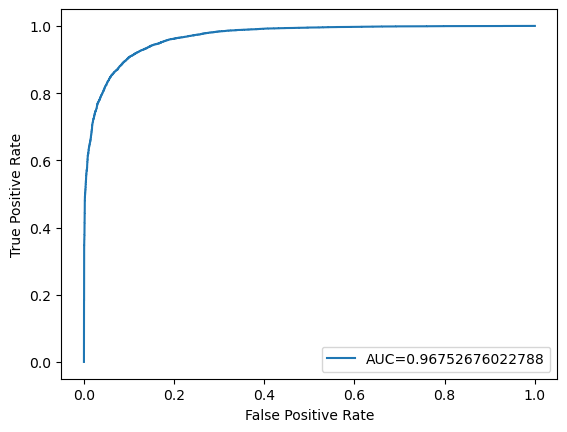

In [300]:
print("\nAUC ROC Curve for SVC Linear Classifier:\n")
# Plot the ROC curve
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

<h2>b) Naive Bayes Gaussian Classifier</h2>

In [301]:
NB_classifier = GaussianNB()

In [302]:
y_pred = cross_val_predict(NB_classifier, X, y, cv=kFolds)

In [303]:
print("\nCross Validation Metrics for NB Gaussian\n\n", classification_report(y, y_pred))


Cross Validation Metrics for NB Gaussian

               precision    recall  f1-score   support

           0       0.76      0.85      0.80     35028
           1       0.83      0.73      0.78     35028

    accuracy                           0.79     70056
   macro avg       0.80      0.79      0.79     70056
weighted avg       0.80      0.79      0.79     70056



In [318]:
NB_classifier.fit(X_train, y_train)

GaussianNB()

In [319]:
cm = confusion_matrix(y, y_pred)
print("\nConfusion Matrix for Gaussian Naive Bayes:\n\n", pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))


Confusion Matrix for Gaussian Naive Bayes:

 Predicted      0      1    All
Actual                        
0          29834   5194  35028
1           9312  25716  35028
All        39146  30910  70056


In [320]:
y_pred_proba = NB_classifier.predict_proba(X_test)[::,1]

In [321]:
# Calculate FPR, TPR, and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)


AUC ROC for Gaussian Naive Bayes Classifier:


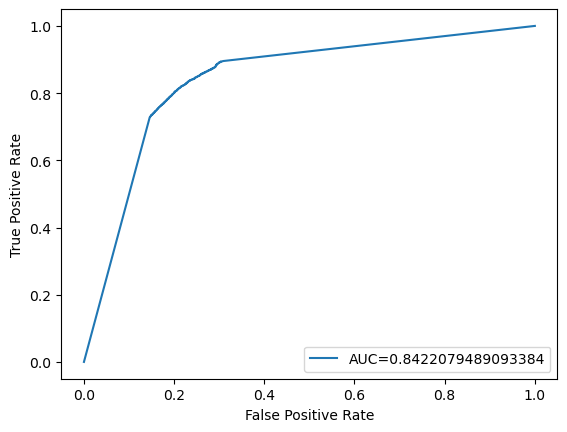

In [322]:
print("\nAUC ROC for Gaussian Naive Bayes Classifier:")
# Plot the ROC curve
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

<h2>c) Logistic Regression Classifier</h2>

In [309]:
logreg_classifier = LogisticRegression(class_weight='balanced',solver='liblinear')

In [310]:
y_pred_logreg = cross_val_predict(logreg_classifier, X, y, cv=kFolds)

In [311]:
print("\nCross Validation Metrics for Logistic Regression:\n\n", classification_report(y, y_pred_logreg))


Cross Validation Metrics for Logistic Regression:

               precision    recall  f1-score   support

           0       0.90      0.91      0.91     35028
           1       0.91      0.90      0.91     35028

    accuracy                           0.91     70056
   macro avg       0.91      0.91      0.91     70056
weighted avg       0.91      0.91      0.91     70056



In [323]:
logreg_classifier.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [324]:
cm_logreg = confusion_matrix(y, y_pred_logreg)
print("\nConfusion Matrix for Logistic Regression:\n\n", pd.crosstab(y, y_pred_logreg, rownames=['Actual'], colnames=['Predicted'], margins=True))


Confusion Matrix for Logistic Regression:

 Predicted      0      1    All
Actual                        
0          31902   3126  35028
1           3369  31659  35028
All        35271  34785  70056


In [325]:
# Predict probabilities
y_pred_proba = logreg_classifier.predict_proba(X_test)[::,1]

In [326]:
# Calculate FPR, TPR, and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)


AUC ROC for Logistic Regression:


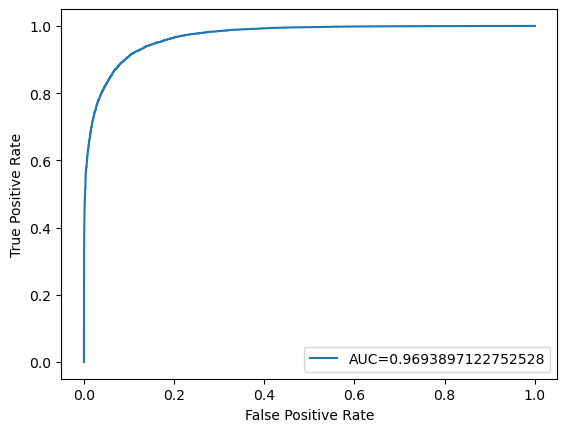

In [327]:
print("\nAUC ROC for Logistic Regression:")
# Plot the ROC curve
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

<h3>Test 9.a-c Discussion: Combining Featuresets and Using SciKit Learn Classifiers</h3>
<br>  
<body>
The combining of several featuresets, mixing BoW features with several quantitative linguistic features gave us a reasonably high score, with
    <b>Accuracy / Precision / Recall / F1 in the 90-91% range </b> on 
    both the <b>Linear SVC</b> and the <b>Logistic Regression</b> classifiers. 
<br><br>
Suprisingly, the Gaussian Naive Bayes classifier produced significantly poorer results--among the lowest we achieved--with a mean accuracy of only 79%. 
</body>

<h1>Test 15b: TF-IDF vectorization with quantitative linguistic features</h1>
<br>
<body>This was a quick experiment with adding several of the quantitative linguistic features used with the unigram Bag of Words featureset to a TF-IDF vectorization. We found that it enhanced performance, yielding some of our highest scores.</body>

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score

In [8]:
data = pd.read_csv('~/WELFake_Dataset.csv', 
                 index_col=None, 
                 header=0,
                 names=['title', 'text', 'label'])

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
data['punct%'] = data['title'].apply(lambda x: percent_punct(x))

In [10]:
data['body_len'] = data['title'].apply(lambda x: len(x) - x.count(" "))

In [11]:
data['all_caps'] = data['title'].apply(lambda x: percent_ALL_CAP(x))

In [16]:
from nltk.tokenize import RegexpTokenizer

def clean_text(text):
    # Lowercase the text and remove unwanted characters
    text = "".join([word.lower() for word in text if (word not in string.punctuation and 
    word not in extra_punct) or word in style_punct])
    
    # Define a RegexpTokenizer that tokenizes asteriks within words (e.g. for obscuring expletives)
    # and keeps hashes with hashtags
    tokenizer = RegexpTokenizer(r'[A-Za-z*]+|\S+')

    # Tokenize the cleaned text
    tokens = tokenizer.tokenize(text)
    
    # stem words using Snowball Stemmer
    text = [stemmer.stem(word) for word in tokens if word not in filter_words]

    return text

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['title', 'punct%', 'all_caps', 'body_len']], data['label'], test_size=0.3)

In [21]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['title'])

tfidf_train = tfidf_vect_fit.transform(X_train['title'])
tfidf_test = tfidf_vect_fit.transform(X_test['title'])

X_train_vect = pd.concat([X_train[['punct%','all_caps', 'body_len']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['punct%', 'all_caps', 'body_len']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,punct%,all_caps,body_len,0,1,2,3,4,5,6,...,22450,22451,22452,22453,22454,22455,22456,22457,22458,22459
0,0.01,0.07,64,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.04,0.25,65,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.08,0.09,64,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.03,0.46,85,0.146367,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.01,0.36,123,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

X_train_vect.columns = X_train_vect.columns.astype(str)
rf_model = rf.fit(X_train_vect, y_train)

X_test_vect.columns = X_test_vect.columns.astype(str)
y_pred = rf_model.predict(X_test_vect)

In [61]:
precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

f1 = round(calculate_f1_score(precision, recall), 3)
print(f"F1: {f1}")

Precision: 0.939 / Recall: 0.951 / Accuracy: 0.944
F1: 0.945


In [63]:
precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=0, average='binary')
print('Neg_Precision: {} / Neg_Recall: {} / Neg_Accuracy: {}'.format(round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

f1 = round(calculate_f1_score(precision, recall), 3)
print(f"Neg_F1: {f1}")

Neg_Precision: 0.949 / Neg_Recall: 0.936 / Neg_Accuracy: 0.944
Neg_F1: 0.942
